# **Homework 3 - Convolutional Neural Network**

Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW03/HW03.pdf

This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. 

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. 

**Hard**: Utilize provided unlabeled data to obtain better results. 

# **基於baseline的分析與改善**

* **network架構**
  * 加深了network的cnn，方便處理更多樣的feature，原本的架構足以處理未做data augmentation的數據，但做完data augmentation後，train不起來
  * 在fully connected加上batch normalization跟dropout，加速訓練跟防止過擬合
* **訓練流程**
  * 一開始在model train到一定程度前，如果直接做半監督的self-labeling，可能會拿到一些亂標的結果，因此直到accuracy > 0.7，才開始做self-labeling的學習
  * train 500個epoch後的acc跟loss：
    * 在230個epoch左右開始做self-labeling，從圖表上可以看到acc跟loss都確實有一段跳躍性的提升
    * 在local的acc可達到0.77，在kaggle上為0.74

    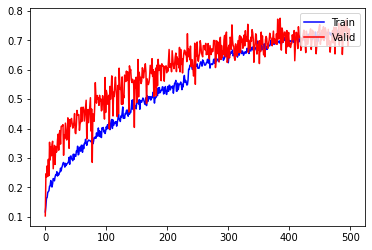
    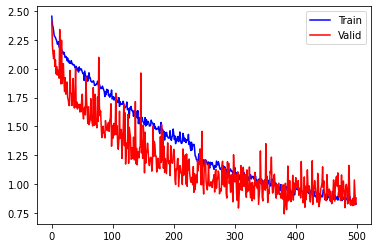

  * 可能的問題：
    * valid的震盪極大：我認為是valid data過少的問題，一共才300多筆，本來就不能穩定的反應model好壞，若希望改善，可以將valid data做水平翻轉，得到兩倍的資料，應該會有所好轉
    * unlabeled data使用率低：由於我一開始將self-labeling的閥值設為0.9，其實大部分的data沒有用到，僅用到1500筆左右，為了解決這個問題，我在原本的model上繼續做training
  * 放寬閥值到0.7後，training 100個epoch的結果：
    * unlabeled data使用率翻倍，可以用到3000多筆資料

    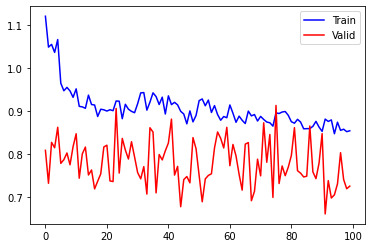
    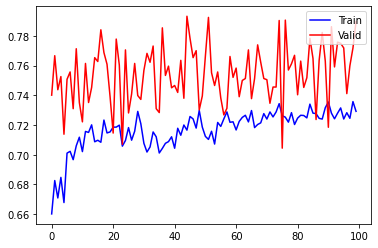



    



# **Result**

* Public: 0.78315
* Private: 0.76867
* 離strong baseline還有0.03的差距，但由於不是很想把時間投入調參，確定方法正確後，這個（包含以後的）練習應該不會為了追求分數重複做測試

# **可以嘗試的作法**
  * 觀察到第二階段的training 20個epoch後並沒有太多改善，而是反覆在作震盪，可能是learning rate過大造成，可以考慮降低learing rate
  * self-labeling的閥值可以再做修改，畢竟近七千筆的unlabeled data，到最後我也只使用了一半，當然如果錯誤標示太多，有可能誤導model
  * 程式裡有註解掉的resnet-18的引入，雖然後來沒有實測，但相信在分類上resnet的model表現應該不錯
  

# **Download Data**

In [ ]:
# Download the dataset
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Unzip the dataset.
!unzip -q food-11.zip

# **Import Packages**

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

# **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
# It is important to do data augmentation in training.

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [ ]:
# A greater batch size usually gives a more stable gradient.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

# **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        x = self.cnn_layers(x)
        x = x.flatten(1)
        x = self.fc_layers(x)
        
        return x

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

def get_pseudo_labels(dataset, model, threshold=0.9):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    for i, batch in enumerate(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    model.train()
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# Call resnet-18
# model = torchvision.models.resnet18(pretrained=False).to(device)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 11).to(device)
# model.device = device

# Read pre-trained model
# model = Classifier().to(device)
# model.load_state_dict(torch.load("model.ckpt"))
# model.device = device

from torchsummary import summary
summary(model, input_size=(3, 128, 128), device=device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=1e-5)

n_epochs = 500
do_semi = True
model_path = "model.ckpt"

best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []

for epoch in range(n_epochs):
    if do_semi and best_acc > 0.7 and epoch % 5 == 0:
        pseudo_set = get_pseudo_labels(unlabeled_set, model)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    # ---------- Train ----------
    model.train()

    train_loss = []
    train_accs = []

    # for batch in tqdm(train_loader):
    for batch in train_loader:
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d} / {n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval()

    valid_loss = []
    valid_accs = []

    # for batch in tqdm(valid_loader):
    for batch in valid_loader:
        imgs, labels = batch

        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d} / {n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # ---------- Record ----------
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)

# **Visualize Result**

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.legend(loc="upper right") 
plt.show()

# **Testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

In [ ]:
model.eval()

predictions = []

for batch in test_loader:
    imgs, labels = batch

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [ ]:
with open("predict.csv", "w") as f:
    f.write("Id,Category\n")

    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")